<a href="https://colab.research.google.com/github/akshit7093/CODSOFT/blob/main/MOVIE_GENRE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'genre-classification-dataset-imdb:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1417162%2F2347441%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240903%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240903T180413Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1fa70d12234f6cc87ee870875380f0055c21db190b5e892c67275c1d2f3e2247b28755ee3c35f831205e6f4771d72dde3c7a4612771c65f0cabe4b0ab860eb78640048ee6a3838b2d9981cd2340f933d0c6af178aae5e146f1ff5ee878c1227b9350f18ba674a245d2e34836925b5aa424631b0ab0cb1b26cf7e802a6846424e06e585e54dfbc53930bc52fcc708674b07243d0d35ec3b32f1aad7eea4897569e37d6f97d48dee33adf617ec299ae2872b183be053f5120c09d10db98a473575a933d9e25b8fd76aeee79f5f42ebb6d228abd9315743ca4eaef6123404f0c4736b941f78cd4db339c48d62cbd1dc666d540817e511767eba6b8a21ced814ae47'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 43729690 bytes downloaded
Downloaded and uncompressed: genre-classification-dataset-imdb
Data source import complete.


# MOVIE GENRE CLASSIFICATION

Importing Libraries


In [13]:
import nltk
import string
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# ***Step 2: Load and Explore the Datat***

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Movie_title  54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Text(0.5, 1.0, 'Genre Distribution')

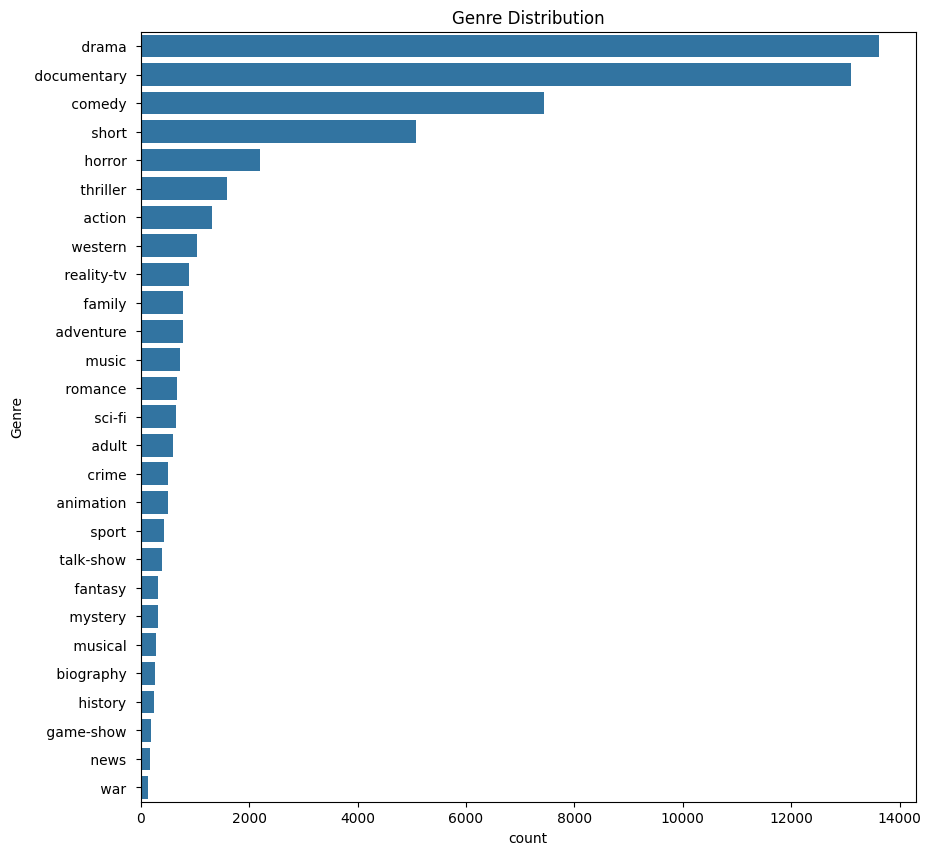

In [3]:
# Training Data
train_data = pd.read_csv('/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt', sep=':::', names=['Movie_title', 'Genre', 'Description'], engine='python')
train_data.describe()
train_data.shape
train_data.info()
train_data.head(10)
train_data.isnull().sum()

# Test Data
test_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Movie_title', 'Description'], engine='python')
test_data.head()

# Distribution of genres in training data
plt.figure(figsize=(10,10))
sns.countplot(data=train_data, order=train_data["Genre"].value_counts().index, y="Genre")
plt.title("Genre Distribution")


In [9]:
stemmer = LancasterStemmer()
stop_words = stopwords.words("english")

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles and email addresses
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Remove special characters
    words = nltk.word_tokenize(text)  # Tokenize text
    text = " ".join([i for i in words if i not in stop_words and len(i) > 2])  # Remove stopwords
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove multiple spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['New_text'] = train_data['Description'].apply(clean_text)
test_data['New_text'] = test_data['Description'].apply(clean_text)


In [10]:
# Tokenize the text for Word2Vec
tokenized_train = [nltk.word_tokenize(text) for text in train_data['New_text']]
tokenized_test = [nltk.word_tokenize(text) for text in test_data['New_text']]

# Train a Word2Vec model
word2vec = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=2, workers=4)
word2vec.build_vocab(tokenized_test, update=True)
word2vec.train(tokenized_test, total_examples=len(tokenized_test), epochs=5)

# Function to get the average word vectors for each document
def get_avg_word2vec(tokens_list, vector, k=100):
    vec = np.zeros(k)
    count = 0
    for word in tokens_list:
        try:
            vec += vector[word]
            count += 1
        except KeyError:  # handling the case where the token is not in the vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

# Create the word vectors for the training and test sets
X_train_word2vec = np.array([get_avg_word2vec(tokens, word2vec.wv, 100) for tokens in tokenized_train])
X_test_word2vec = np.array([get_avg_word2vec(tokens, word2vec.wv, 100) for tokens in tokenized_test])


In [11]:
# Split the data into training and validation sets
X = X_train_word2vec
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Scale the word vectors to the range [0, 1]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Use the same scaler fitted on training data

# Train the Multinomial Naive Bayes model on the scaled data
nb = MultinomialNB()
nb.fit(X_train_scaled, y_train)

# Predict on the validation set (also scaled)
y_pred_nb = nb.predict(X_val_scaled)

print("Naive Bayes Validation Accuracy:", accuracy_score(y_val, y_pred_nb))
print(classification_report(y_val, y_pred_nb))

Naive Bayes Validation Accuracy: 0.4275569491838052


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.00      0.00      0.00      1443
       crime        0.00      0.00      0.00       107
 documentary        0.52      0.87      0.65      2659
       drama        0.36      0.86      0.51      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        0.00      0.00      0.00       144
     musical        0.00      0.00      0.00        50
     mystery        0.00      0.00      0.00        56
        n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

print("Random Forest Validation Accuracy:", accuracy_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))


Random Forest Validation Accuracy: 0.5228257862215254


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.39      0.15      0.22       263
       adult        0.62      0.04      0.08       112
   adventure        0.32      0.05      0.09       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.42      0.49      0.45      1443
       crime        0.50      0.01      0.02       107
 documentary        0.60      0.88      0.71      2659
       drama        0.48      0.76      0.59      2697
      family        0.80      0.03      0.05       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.86      0.47      0.61        40
     history        0.00      0.00      0.00        45
      horror        0.52      0.34      0.41       431
       music        0.61      0.30      0.40       144
     musical        0.00      0.00      0.00        50
     mystery        0.00      0.00      0.00        56
        n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=10, alpha=1e-4,
                    solver='adam', verbose=1, random_state=42, tol=1e-4)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_val)

print("MLP Validation Accuracy:", accuracy_score(y_val, y_pred_mlp))
print(classification_report(y_val, y_pred_mlp))


Iteration 1, loss = 1.84521354
Iteration 2, loss = 1.51001985
Iteration 3, loss = 1.44529521
Iteration 4, loss = 1.41471753
Iteration 5, loss = 1.39802238
Iteration 6, loss = 1.37786394
Iteration 7, loss = 1.36607568
Iteration 8, loss = 1.35255083
Iteration 9, loss = 1.34339891
Iteration 10, loss = 1.33224826
MLP Validation Accuracy: 0.572904177810569


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.33      0.29      0.31       263
       adult        0.49      0.37      0.42       112
   adventure        0.28      0.12      0.16       139
   animation        0.34      0.13      0.19       104
   biography        0.00      0.00      0.00        61
      comedy        0.49      0.58      0.53      1443
       crime        0.33      0.03      0.05       107
 documentary        0.68      0.85      0.76      2659
       drama        0.56      0.73      0.64      2697
      family        0.42      0.09      0.15       150
     fantasy        0.31      0.05      0.09        74
   game-show        0.76      0.55      0.64        40
     history        0.00      0.00      0.00        45
      horror        0.52      0.65      0.58       431
       music        0.55      0.53      0.54       144
     musical        0.00      0.00      0.00        50
     mystery        0.00      0.00      0.00        56
        n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# Fit the VotingClassifier using scaled data for MultinomialNB
voting_clf = VotingClassifier(estimators=[
    ('nb', nb),
    ('rf', rf),
    ('mlp', mlp)], voting='soft')
voting_clf.fit(X_train_scaled, y_train)  # Use scaled data here
y_pred_voting = voting_clf.predict(X_val_scaled)  # Predict on scaled validation data

print("Voting Classifier Validation Accuracy:", accuracy_score(y_val, y_pred_voting))
print(classification_report(y_val, y_pred_voting))


Iteration 1, loss = 2.20304401
Iteration 2, loss = 1.85614776
Iteration 3, loss = 1.72183082
Iteration 4, loss = 1.65453889
Iteration 5, loss = 1.61850598
Iteration 6, loss = 1.58800358
Iteration 7, loss = 1.56768570
Iteration 8, loss = 1.54604370
Iteration 9, loss = 1.53365949
Iteration 10, loss = 1.51415380


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Voting Classifier Validation Accuracy: 0.5290048879461403


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.40      0.10      0.15       263
       adult        0.67      0.05      0.10       112
   adventure        0.25      0.01      0.01       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.43      0.47      0.45      1443
       crime        0.00      0.00      0.00       107
 documentary        0.60      0.89      0.72      2659
       drama        0.48      0.79      0.60      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.86      0.45      0.59        40
     history        0.00      0.00      0.00        45
      horror        0.57      0.43      0.49       431
       music        0.59      0.31      0.40       144
     musical        0.00      0.00      0.00        50
     mystery        0.00      0.00      0.00        56
        n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# Use the trained model to make predictions on the test data
X_test_predictions = voting_clf.predict(X_test_word2vec)
test_data['Predicted_Genre'] = X_test_predictions

# Save the test_data DataFrame with predicted genres to a CSV file
test_data.to_csv('predicted_genres.csv', index=False)

# Display the 'test_data' DataFrame with predicted genres
print(test_data.head())


   Id                    Movie_title  \
0   1          Edgar's Lunch (1998)    
1   2      La guerra de papá (1977)    
2   3   Off the Beaten Track (2010)    
3   4        Meu Amigo Hindu (2015)    
4   5             Er nu zhai (1955)    

                                         Description  \
0   L.R. Brane loves his life - his car, his apar...   
1   Spain, March 1964: Quico is a very naughty ch...   
2   One year in the life of Albin and his family ...   
3   His father has died, he hasn't spoken with hi...   
4   Before he was known internationally as a mart...   

                                            New_text Predicted_Genre  
0  brane loves life car apartment job especially ...          drama   
1  spain march quico naughty child three belongin...          drama   
2  one year life albin family shepherds north tra...    documentary   
3  father died n't spoken brother years serious c...          drama   
4  known internationally martial arts superstar b...          drama

In [ ]:
# Training Data
train_data = pd.read_csv('/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt', sep=':::', names=['Movie_title', 'Genre', 'Description'], engine='python')

In [ ]:
train_data.describe()

In [ ]:
train_data.shape

In [ ]:
train_data.info()

In [ ]:
train_data.head(10)

In [ ]:
train_data.isnull().sum()

In [ ]:
# Test data

test_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Movie_title', 'Description'], engine='python')
test_data.head()

# Exploratory Data Analysis (EDA) & Data Visualization

In [ ]:
# distribution of genres in training data
plt.figure(figsize=(10,10))
sns.countplot(data=train_data,order= train_data["Genre"].value_counts().index,y="Genre")
plt.title("Genre Distribution")

# Data Preprocessing and Text Cleaning

In [ ]:
stemmer = LancasterStemmer()
stop_words=stopwords.words("english")

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles and email addresses
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Remove special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text) #tokenize text
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove multiple spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['New_text'] = train_data['Description'].apply(clean_text)
test_data['New_text'] = test_data['Description'].apply(clean_text)

In [ ]:
# # Calculate the length of cleaned text
# train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)
# # Visualize the distribution of text lengths
# plt.figure(figsize=(8, 7))
# sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
# plt.xlabel('Length', fontsize=14, fontweight='bold')
# plt.ylabel('Frequency', fontsize=14, fontweight='bold')
# plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
# plt.show()

In [ ]:
test_data.head()

Text Vectorization Using TF-IDF

In [ ]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(train_data['New_text'])
X_test = tfidf.transform(test_data['New_text'])

Data Splitting for training and validation

In [ ]:
# training and validation sets
X = X_train
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Model Training & Evaluation

Multinomial Naive Bayes classifier

In [ ]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

In [ ]:
y_pred = nb.predict(X_val) # on validation set

In [ ]:
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

In [ ]:
print(classification_report(y_val, y_pred))

SVC Classifier

In [ ]:
# svc = SVC()
# svc.fit(X_train, y_train)

In [ ]:
# y_pred = svc.predict(X_val) # on validation set

In [ ]:
# svc.score(X_train, y_train)

In [ ]:
# print(classification_report(y_val, y_pred))

# Predictions on Test Dataset

In [ ]:
# Use the trained model to make predictions on the test data
X_test_predictions = nb.predict(X_test)
test_data['Predicted_Genre'] = X_test_predictions

In [ ]:
# Save the test_data DataFrame with predicted genres to a CSV file
test_data.to_csv('predicted_genres.csv', index=False)

# Display the 'test_data' DataFrame with predicted genres
print(test_data)